## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 12 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp007'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 12 # 6
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 3 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([12, 224, 224])

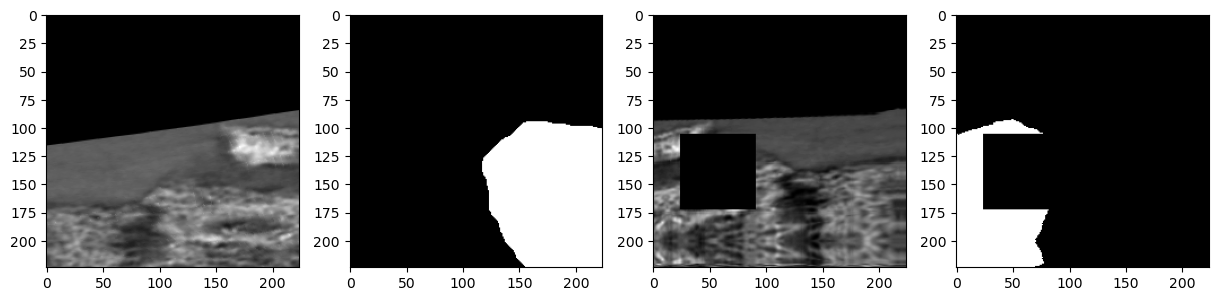

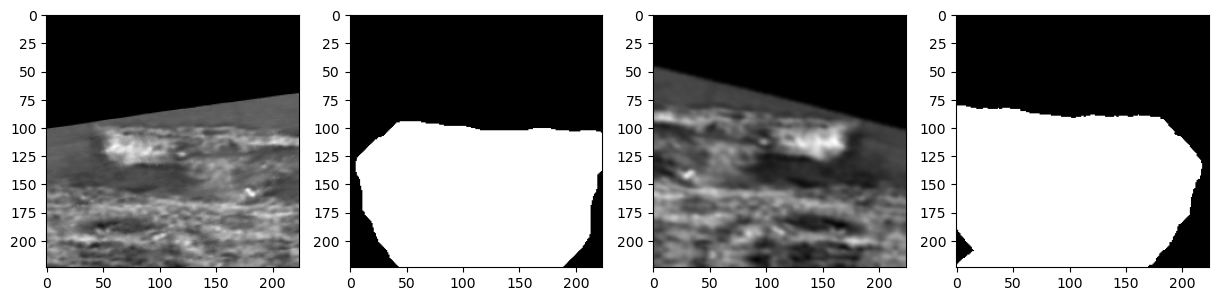

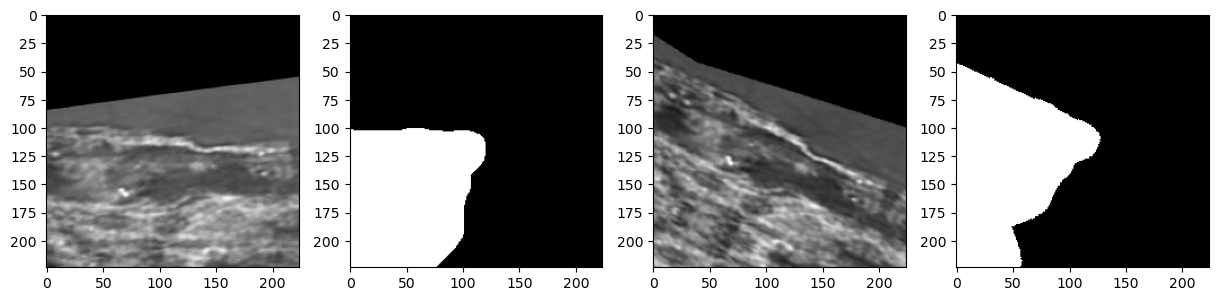

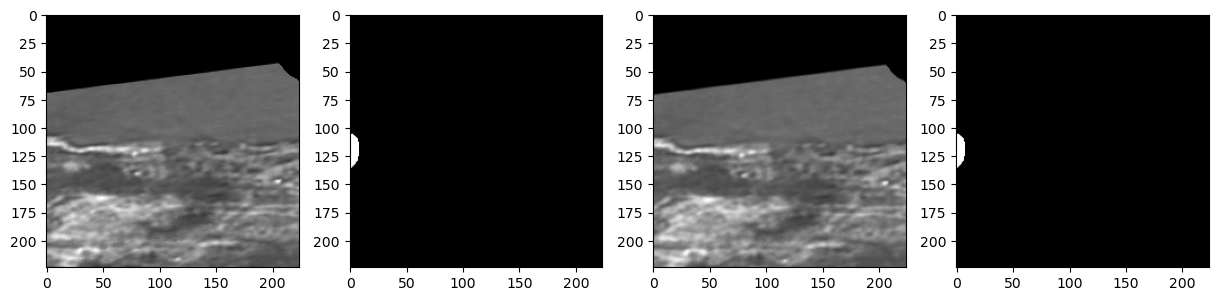

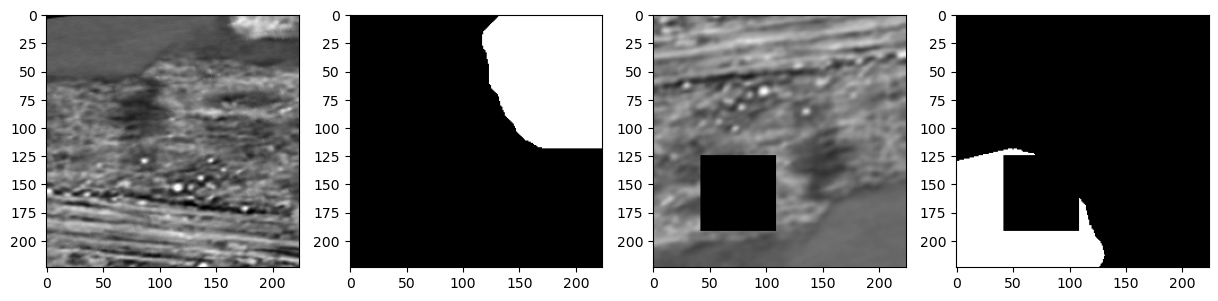

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48110

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.15029577740340225
th: 0.15, fbeta: 0.17456757321501104
th: 0.2, fbeta: 0.20668325251800873
th: 0.25, fbeta: 0.24805220925669416
th: 0.3, fbeta: 0.2939201717058391
th: 0.35, fbeta: 0.3326135183625193
th: 0.4, fbeta: 0.3478059905255346
th: 0.45, fbeta: 0.32208506323954156


best_th: 0.4, fbeta: 0.3478059905255346
Epoch 1 - avg_train_loss: 0.4003  avg_val_loss: 0.2844  time: 238s
Epoch 1 - avgScore: 0.3478
Epoch 1 - Save Best Score: 0.3478 Model
Epoch 1 - Save Best Loss: 0.2844 Model


th: 0.5, fbeta: 0.23557672199080107


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.17645120399543665
th: 0.15, fbeta: 0.24246146600230578
th: 0.2, fbeta: 0.3072925418007824
th: 0.25, fbeta: 0.3562420672193622
th: 0.3, fbeta: 0.3924509017110474
th: 0.35, fbeta: 0.4130758080338332
th: 0.4, fbeta: 0.418133612729679
th: 0.45, fbeta: 0.40405875918191214


best_th: 0.4, fbeta: 0.418133612729679
Epoch 2 - avg_train_loss: 0.3115  avg_val_loss: 0.2416  time: 239s
Epoch 2 - avgScore: 0.4181
Epoch 2 - Save Best Score: 0.4181 Model
Epoch 2 - Save Best Loss: 0.2416 Model


th: 0.5, fbeta: 0.35986083804041513


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.23686217137915386
th: 0.15, fbeta: 0.32513613245413225
th: 0.2, fbeta: 0.3652402778681257
th: 0.25, fbeta: 0.39751606059740063
th: 0.3, fbeta: 0.420808281943838
th: 0.35, fbeta: 0.4371245181378535
th: 0.4, fbeta: 0.4485515691062882
th: 0.45, fbeta: 0.454926143094918


best_th: 0.45, fbeta: 0.454926143094918
Epoch 3 - avg_train_loss: 0.2710  avg_val_loss: 0.2088  time: 240s
Epoch 3 - avgScore: 0.4549
Epoch 3 - Save Best Score: 0.4549 Model
Epoch 3 - Save Best Loss: 0.2088 Model


th: 0.5, fbeta: 0.45429940733698587


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23673489748800797
th: 0.15, fbeta: 0.2749055142205312
th: 0.2, fbeta: 0.31026243695257955
th: 0.25, fbeta: 0.3462620600243204
th: 0.3, fbeta: 0.3775516164850092
th: 0.35, fbeta: 0.402857741933303
th: 0.4, fbeta: 0.4250350836183504


best_th: 0.5, fbeta: 0.46141064256933767
Epoch 4 - avg_train_loss: 0.2479  avg_val_loss: 0.2182  time: 240s


th: 0.45, fbeta: 0.4440850763842056
th: 0.5, fbeta: 0.46141064256933767


Epoch 4 - avgScore: 0.4614
Epoch 4 - Save Best Score: 0.4614 Model
Epoch 4 - Save Best Loss: 0.2182 Model


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3089185652073061
th: 0.15, fbeta: 0.3685259987079769
th: 0.2, fbeta: 0.41230474166157705
th: 0.25, fbeta: 0.4457747267704867
th: 0.3, fbeta: 0.47374359159797313
th: 0.35, fbeta: 0.5001963800119241
th: 0.4, fbeta: 0.5214278372667821
th: 0.45, fbeta: 0.5359445514920109


best_th: 0.5, fbeta: 0.5429524819568259
Epoch 5 - avg_train_loss: 0.2343  avg_val_loss: 0.1935  time: 238s
Epoch 5 - avgScore: 0.5430
Epoch 5 - Save Best Score: 0.5430 Model
Epoch 5 - Save Best Loss: 0.1935 Model


th: 0.5, fbeta: 0.5429524819568259


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23603304369916644
th: 0.15, fbeta: 0.269004807923325
th: 0.2, fbeta: 0.2978134981183747
th: 0.25, fbeta: 0.3232966971461488
th: 0.3, fbeta: 0.34650030021334666
th: 0.35, fbeta: 0.3695435925284738
th: 0.4, fbeta: 0.39175278758939
th: 0.45, fbeta: 0.414743737069894


best_th: 0.5, fbeta: 0.4334343192255247
Epoch 6 - avg_train_loss: 0.2231  avg_val_loss: 0.2662  time: 239s
Epoch 6 - avgScore: 0.4334


th: 0.5, fbeta: 0.4334343192255247


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26555890344029215
th: 0.15, fbeta: 0.3163824756723436
th: 0.2, fbeta: 0.3585066090596271
th: 0.25, fbeta: 0.39039794807416384
th: 0.3, fbeta: 0.411960590640311
th: 0.35, fbeta: 0.4293686753693244
th: 0.4, fbeta: 0.44798242702796953
th: 0.45, fbeta: 0.46109424697175644


best_th: 0.5, fbeta: 0.4731648258314141
Epoch 7 - avg_train_loss: 0.2109  avg_val_loss: 0.2205  time: 239s
Epoch 7 - avgScore: 0.4732


th: 0.5, fbeta: 0.4731648258314141


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31573265434096864
th: 0.15, fbeta: 0.35003277683165646
th: 0.2, fbeta: 0.37934978638931277
th: 0.25, fbeta: 0.4054544410810105
th: 0.3, fbeta: 0.4287186447208592
th: 0.35, fbeta: 0.4505512403437521
th: 0.4, fbeta: 0.47076024217559503
th: 0.45, fbeta: 0.48731267825468766


best_th: 0.5, fbeta: 0.5020438378553637
Epoch 8 - avg_train_loss: 0.2017  avg_val_loss: 0.2260  time: 249s
Epoch 8 - avgScore: 0.5020


th: 0.5, fbeta: 0.5020438378553637


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3199205692669046
th: 0.15, fbeta: 0.37015715118058934
th: 0.2, fbeta: 0.411512055758482
th: 0.25, fbeta: 0.44189405363226614
th: 0.3, fbeta: 0.4703259009060751
th: 0.35, fbeta: 0.4928265175226279
th: 0.4, fbeta: 0.5071556835215947


best_th: 0.5, fbeta: 0.514228748434326
Epoch 9 - avg_train_loss: 0.1883  avg_val_loss: 0.2131  time: 242s
Epoch 9 - avgScore: 0.5142


th: 0.45, fbeta: 0.5130521488507481
th: 0.5, fbeta: 0.514228748434326


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26164513680697893
th: 0.15, fbeta: 0.29139410673676436
th: 0.2, fbeta: 0.31838678669989595
th: 0.25, fbeta: 0.3451663525737671
th: 0.3, fbeta: 0.37075852304143503
th: 0.35, fbeta: 0.39543892146392157
th: 0.4, fbeta: 0.42368342878113385
th: 0.45, fbeta: 0.4505918395868017


best_th: 0.5, fbeta: 0.4748894577353886
Epoch 10 - avg_train_loss: 0.1780  avg_val_loss: 0.2323  time: 241s
Epoch 10 - avgScore: 0.4749


th: 0.5, fbeta: 0.4748894577353886


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2550204665748707
th: 0.15, fbeta: 0.28909012348436497
th: 0.2, fbeta: 0.3170631152104485
th: 0.25, fbeta: 0.33929935563032104
th: 0.3, fbeta: 0.3611410676212089
th: 0.35, fbeta: 0.3822651351171553
th: 0.4, fbeta: 0.400199364638288
th: 0.45, fbeta: 0.4141134089921115


best_th: 0.5, fbeta: 0.4259001612610026
Epoch 11 - avg_train_loss: 0.1660  avg_val_loss: 0.2525  time: 241s
Epoch 11 - avgScore: 0.4259


th: 0.5, fbeta: 0.4259001612610026


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.27109043650314685
th: 0.15, fbeta: 0.3049743306413505
th: 0.2, fbeta: 0.33597925685829266
th: 0.25, fbeta: 0.3652537900202384
th: 0.3, fbeta: 0.3936587044332059
th: 0.35, fbeta: 0.41815218967052337
th: 0.4, fbeta: 0.437033049011112
th: 0.45, fbeta: 0.45214997878432767


best_th: 0.5, fbeta: 0.46106797436931896
Epoch 12 - avg_train_loss: 0.1536  avg_val_loss: 0.2384  time: 244s
Epoch 12 - avgScore: 0.4611


th: 0.5, fbeta: 0.46106797436931896


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.25714598021696417
th: 0.15, fbeta: 0.2818424887802965
th: 0.2, fbeta: 0.3053473878451649
th: 0.25, fbeta: 0.3277574087591034
th: 0.3, fbeta: 0.34851312385059496
th: 0.35, fbeta: 0.36838478395479046
th: 0.4, fbeta: 0.3881668990614444
th: 0.45, fbeta: 0.4067567558444906


best_th: 0.5, fbeta: 0.4239839282500986
Epoch 13 - avg_train_loss: 0.1446  avg_val_loss: 0.2622  time: 240s
Epoch 13 - avgScore: 0.4240


th: 0.5, fbeta: 0.4239839282500986


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29577021654406405
th: 0.15, fbeta: 0.32997245053555424
th: 0.2, fbeta: 0.3576694196936165
th: 0.25, fbeta: 0.38034237539047744
th: 0.3, fbeta: 0.39798388840643395
th: 0.35, fbeta: 0.4131846617346204
th: 0.4, fbeta: 0.42848511592937566
th: 0.45, fbeta: 0.44074285737868485


best_th: 0.5, fbeta: 0.45110136111391325
Epoch 14 - avg_train_loss: 0.1354  avg_val_loss: 0.2579  time: 246s
Epoch 14 - avgScore: 0.4511


th: 0.5, fbeta: 0.45110136111391325


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2601132338758906
th: 0.15, fbeta: 0.292686012407654
th: 0.2, fbeta: 0.3214796027109139
th: 0.25, fbeta: 0.3472628134600582
th: 0.3, fbeta: 0.37059371669960406
th: 0.35, fbeta: 0.39525369682572375
th: 0.4, fbeta: 0.4182936974649952


best_th: 0.5, fbeta: 0.45700640682585125
Epoch 15 - avg_train_loss: 0.1273  avg_val_loss: 0.2532  time: 244s
Epoch 15 - avgScore: 0.4570


th: 0.45, fbeta: 0.4379773954055165
th: 0.5, fbeta: 0.45700640682585125


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2569496001478067
th: 0.15, fbeta: 0.28178543055387945
th: 0.2, fbeta: 0.304507582651874
th: 0.25, fbeta: 0.3255150468922167
th: 0.3, fbeta: 0.34549498457184835
th: 0.35, fbeta: 0.3642614425879404
th: 0.4, fbeta: 0.3819905847023682
th: 0.45, fbeta: 0.3974940722735519


best_th: 0.5, fbeta: 0.4138289190811518
Epoch 16 - avg_train_loss: 0.1200  avg_val_loss: 0.2955  time: 245s
Epoch 16 - avgScore: 0.4138


th: 0.5, fbeta: 0.4138289190811518


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29365471422436
th: 0.15, fbeta: 0.32140553815318224
th: 0.2, fbeta: 0.3432897869372925
th: 0.25, fbeta: 0.36173665621568557
th: 0.3, fbeta: 0.3795719710503469
th: 0.35, fbeta: 0.3954931201967968
th: 0.4, fbeta: 0.4113027744223242
th: 0.45, fbeta: 0.4219454202353838


best_th: 0.5, fbeta: 0.43123204124827363
Epoch 17 - avg_train_loss: 0.1136  avg_val_loss: 0.2779  time: 246s
Epoch 17 - avgScore: 0.4312


th: 0.5, fbeta: 0.43123204124827363


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3127173082334187
th: 0.15, fbeta: 0.3432185235551855
th: 0.2, fbeta: 0.3697652591443688
th: 0.25, fbeta: 0.38840966758942974
th: 0.3, fbeta: 0.40338393214064877
th: 0.35, fbeta: 0.4170719545547798
th: 0.4, fbeta: 0.4282321621165504
th: 0.45, fbeta: 0.43959257113844064


best_th: 0.5, fbeta: 0.44559471777404747
Epoch 18 - avg_train_loss: 0.1059  avg_val_loss: 0.2642  time: 244s
Epoch 18 - avgScore: 0.4456


th: 0.5, fbeta: 0.44559471777404747


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3226055139755192
th: 0.15, fbeta: 0.34848361272775424
th: 0.2, fbeta: 0.36842419382401603
th: 0.25, fbeta: 0.38809042751377165
th: 0.3, fbeta: 0.40952521634462713
th: 0.35, fbeta: 0.42980356636628847
th: 0.4, fbeta: 0.4467152579393529
th: 0.45, fbeta: 0.46243357158788806


best_th: 0.5, fbeta: 0.47410736204769083
Epoch 19 - avg_train_loss: 0.0996  avg_val_loss: 0.2776  time: 244s
Epoch 19 - avgScore: 0.4741


th: 0.5, fbeta: 0.47410736204769083


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3228905654019754
th: 0.15, fbeta: 0.35185980209117346
th: 0.2, fbeta: 0.3760984635789111
th: 0.25, fbeta: 0.39651369373710177
th: 0.3, fbeta: 0.4150935248497727
th: 0.35, fbeta: 0.4294000214954803
th: 0.4, fbeta: 0.4443932499562719
th: 0.45, fbeta: 0.45691939270836757


best_th: 0.5, fbeta: 0.4664510590810981
Epoch 20 - avg_train_loss: 0.0940  avg_val_loss: 0.2659  time: 247s
Epoch 20 - avgScore: 0.4665


th: 0.5, fbeta: 0.4664510590810981


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29199428938578426
th: 0.15, fbeta: 0.31475732662375333
th: 0.2, fbeta: 0.33524993258404734
th: 0.25, fbeta: 0.35700220088275336
th: 0.3, fbeta: 0.3767662905076348
th: 0.35, fbeta: 0.3927641958435832
th: 0.4, fbeta: 0.4053099650951334


best_th: 0.5, fbeta: 0.4332846347593462


th: 0.45, fbeta: 0.4190369837323426
th: 0.5, fbeta: 0.4332846347593462


Epoch 21 - avg_train_loss: 0.0893  avg_val_loss: 0.3023  time: 245s
Epoch 21 - avgScore: 0.4333


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3039240461804212
th: 0.15, fbeta: 0.3327018279081989
th: 0.2, fbeta: 0.35973718252589554
th: 0.25, fbeta: 0.38290782693038394
th: 0.3, fbeta: 0.40282487181893173
th: 0.35, fbeta: 0.421646458202996
th: 0.4, fbeta: 0.43847535435738205
th: 0.45, fbeta: 0.4521145655806032


best_th: 0.5, fbeta: 0.46467415041596644
Epoch 22 - avg_train_loss: 0.0852  avg_val_loss: 0.2767  time: 244s
Epoch 22 - avgScore: 0.4647


th: 0.5, fbeta: 0.46467415041596644


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3367441879554287
th: 0.15, fbeta: 0.37001840170894523
th: 0.2, fbeta: 0.3976196241726195
th: 0.25, fbeta: 0.42264926071008774
th: 0.3, fbeta: 0.44195254835593706
th: 0.35, fbeta: 0.4568625134216075
th: 0.4, fbeta: 0.4685130717123571


best_th: 0.5, fbeta: 0.48399612506788114
Epoch 23 - avg_train_loss: 0.0807  avg_val_loss: 0.2747  time: 245s
Epoch 23 - avgScore: 0.4840


th: 0.45, fbeta: 0.4772773476415183
th: 0.5, fbeta: 0.48399612506788114


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.306815167461737
th: 0.15, fbeta: 0.3336630936458202
th: 0.2, fbeta: 0.35734230099002434
th: 0.25, fbeta: 0.37979430783867496
th: 0.3, fbeta: 0.4006557710706789
th: 0.35, fbeta: 0.42105303173443676
th: 0.4, fbeta: 0.4386052069990097
th: 0.45, fbeta: 0.45498131625722055


best_th: 0.5, fbeta: 0.46772705712767254
Epoch 24 - avg_train_loss: 0.0778  avg_val_loss: 0.2859  time: 239s
Epoch 24 - avgScore: 0.4677


th: 0.5, fbeta: 0.46772705712767254


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34230550534792337
th: 0.15, fbeta: 0.37277225423135246
th: 0.2, fbeta: 0.3994537351296814
th: 0.25, fbeta: 0.42167301792324957
th: 0.3, fbeta: 0.44207243328824547
th: 0.35, fbeta: 0.45931860609479447
th: 0.4, fbeta: 0.47427767908482377
th: 0.45, fbeta: 0.48505337287756806


best_th: 0.5, fbeta: 0.4903813038022894
Epoch 25 - avg_train_loss: 0.0752  avg_val_loss: 0.2902  time: 240s
Epoch 25 - avgScore: 0.4904


th: 0.5, fbeta: 0.4903813038022894


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31152456612061585
th: 0.15, fbeta: 0.33574958645323266
th: 0.2, fbeta: 0.3591781707432923
th: 0.25, fbeta: 0.3819089976893018
th: 0.3, fbeta: 0.40393956236228223
th: 0.35, fbeta: 0.4221947960974093
th: 0.4, fbeta: 0.43980053129328656
th: 0.45, fbeta: 0.45467747743733217


best_th: 0.5, fbeta: 0.46491377283333485
Epoch 26 - avg_train_loss: 0.0720  avg_val_loss: 0.2975  time: 237s
Epoch 26 - avgScore: 0.4649


th: 0.5, fbeta: 0.46491377283333485


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30408916635303046
th: 0.15, fbeta: 0.32731474195670923
th: 0.2, fbeta: 0.3494691011079303
th: 0.25, fbeta: 0.3727798709917692
th: 0.3, fbeta: 0.3953003425775319
th: 0.35, fbeta: 0.4137858711274716
th: 0.4, fbeta: 0.43083296580339575
th: 0.45, fbeta: 0.4488476713901698


best_th: 0.5, fbeta: 0.46497806576093403
Epoch 27 - avg_train_loss: 0.0701  avg_val_loss: 0.2989  time: 238s
Epoch 27 - avgScore: 0.4650


th: 0.5, fbeta: 0.46497806576093403


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3067442398461119
th: 0.15, fbeta: 0.3292554741450782
th: 0.2, fbeta: 0.35008819821781234
th: 0.25, fbeta: 0.3710198382359581
th: 0.3, fbeta: 0.390043571524553
th: 0.35, fbeta: 0.4060917482492433
th: 0.4, fbeta: 0.42276537935062997


best_th: 0.5, fbeta: 0.45148525429449626
Epoch 28 - avg_train_loss: 0.0686  avg_val_loss: 0.3052  time: 239s
Epoch 28 - avgScore: 0.4515


th: 0.45, fbeta: 0.43818477891415425
th: 0.5, fbeta: 0.45148525429449626


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3312690903384687
th: 0.15, fbeta: 0.35699117418097037
th: 0.2, fbeta: 0.38196339357276454
th: 0.25, fbeta: 0.405909567775505
th: 0.3, fbeta: 0.426509297562498
th: 0.35, fbeta: 0.44329937000549685
th: 0.4, fbeta: 0.4581777033101891
th: 0.45, fbeta: 0.4710921238379243


best_th: 0.5, fbeta: 0.47990657660767605
Epoch 29 - avg_train_loss: 0.0673  avg_val_loss: 0.3105  time: 239s
Epoch 29 - avgScore: 0.4799


th: 0.5, fbeta: 0.47990657660767605


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3144515233756714
th: 0.15, fbeta: 0.3384151802327494
th: 0.2, fbeta: 0.3614425637439231
th: 0.25, fbeta: 0.3831826054259177
th: 0.3, fbeta: 0.40176230884999525
th: 0.35, fbeta: 0.4194096577695711
th: 0.4, fbeta: 0.43590677449416976


best_th: 0.5, fbeta: 0.4654148461088366
Epoch 30 - avg_train_loss: 0.0663  avg_val_loss: 0.3063  time: 238s
Epoch 30 - avgScore: 0.4654


th: 0.45, fbeta: 0.45154426069996434
th: 0.5, fbeta: 0.4654148461088366


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.3089185652073061
th: 0.15, fbeta: 0.3685259987079769
th: 0.2, fbeta: 0.41230474166157705
th: 0.25, fbeta: 0.4457747267704867
th: 0.3, fbeta: 0.47374359159797313
th: 0.35, fbeta: 0.5001963800119241
th: 0.4, fbeta: 0.5214278372667821
th: 0.45, fbeta: 0.5359445514920109


best_th: 0.5, fbeta: 0.5429524819568259


th: 0.5, fbeta: 0.5429524819568259


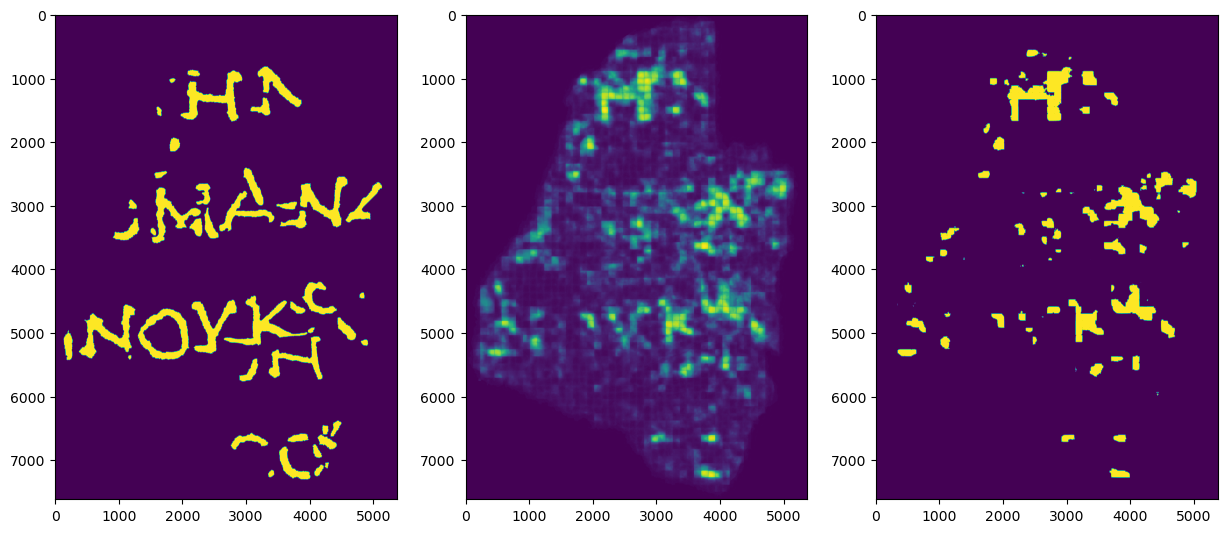

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([2.2967402e+07, 7.8649090e+06, 2.9650860e+06, 1.6344790e+06,
        1.0295630e+06, 7.3471800e+05, 6.0179500e+05, 4.6753800e+05,
        3.5708900e+05, 3.2271400e+05, 2.7767300e+05, 2.6084100e+05,
        2.5186800e+05, 2.5799200e+05, 2.4367400e+05, 2.2406600e+05,
        2.1791700e+05, 1.7025100e+05, 7.6795000e+04, 1.7246000e+04]),
 array([2.13559952e-05, 4.76766507e-02, 9.53319454e-02, 1.42987240e-01,
        1.90642535e-01, 2.38297830e-01, 2.85953124e-01, 3.33608419e-01,
        3.81263714e-01, 4.28919008e-01, 4.76574303e-01, 5.24229598e-01,
        5.71884892e-01, 6.19540187e-01, 6.67195482e-01, 7.14850777e-01,
        7.62506071e-01, 8.10161366e-01, 8.57816661e-01, 9.05471955e-01,
        9.53127250e-01]),
 <BarContainer object of 20 artists>)

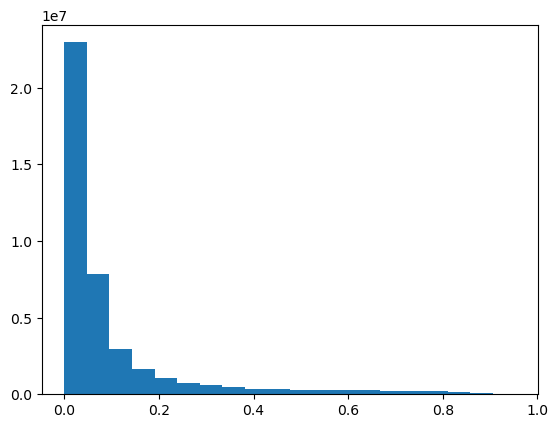

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000